# Titanic analysis via Common ML libs

## Infra and imports

In [69]:
import copy
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from sklearn.metrics import confusion_matrix

In [28]:
def plot_confusion_matrix(cm, classes=["Didn't survive", "Survive" ],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
def get_pred_score(label, pred):
    """
    Get prediction score (Higher is better)
    """
    tp = sum((pred == 1)&(label == 1))
    tn = sum((pred == 0)&(label == 0))
    fp = sum((pred == 1)&(label == 0))
    fn = sum((pred == 0)&(label == 1))
    return 2*tp +1*tn -1*fp -2*fn

## Load data & pre-processing

In [37]:
df = pd.read_csv("../data/train.csv")
# Remove presumed non informative columns
df = df.drop(['Ticket','Cabin', 'PassengerId', 'Name'], axis=1)
# Remove NaN values
df = df.dropna() 
df.reset_index(drop=True, inplace=True)

In [31]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [33]:
def df_pre_processing(df):
    """ Transform df to int fvs and labels"""
    labels = df['Survived']
    fvs = copy.deepcopy(df)
    fvs.drop(['Survived'], axis=1, inplace=True)
    fvs['Sex'] = fvs.apply(lambda x: 1 if x['Sex'] == 'male' else 0, axis=1)
    fvs['Embarked'] = fvs.apply(lambda x: ord(x['Embarked']), axis=1)
    return fvs, labels    

In [41]:
x, y = df_pre_processing(df)

## Decision tree

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.3,
            train_size=None)
Confusion matrix, without normalization
[[123   4]
 [ 33  54]]


Clf score: 161


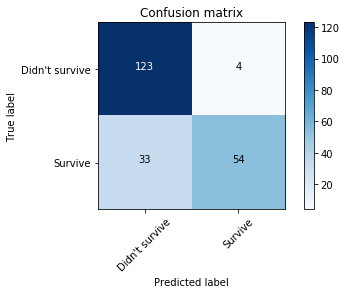

In [78]:
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(x, y)
print(sss)       

for train_index, test_index in sss.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(x_train, y_train)
pred = clf.predict(x_test)
plot_confusion_matrix(confusion_matrix(y_test, pred))
print(f'\n\nClf score: {get_pred_score(y_test, pred)}')

In [80]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=fvs.columns,  
                         class_names=['Did not survive', 'Survive'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
# graph 

## Random forest

Confusion matrix, without normalization
[[115  12]
 [ 24  63]]


Clf score: 181


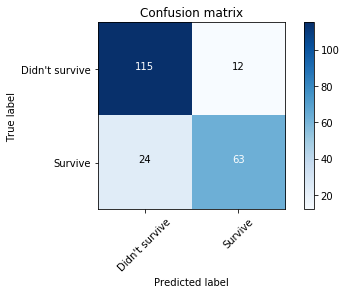

In [82]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(x_train, y_train)

pred = clf.predict(x_test)
plot_confusion_matrix(confusion_matrix(y_test, pred))
print(f'\n\nClf score: {get_pred_score(y_test, pred)}')

## Feature importance

Add feature importance
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Feature ranking:
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
1. feature Age (0.2720590268612246)
2. feature Fare (0.2531086602320211)
3. feature Sex (0.24949982643609964)
4. feature Pclass (0.11002740658984655)
5. feature SibSp (0.046187603650222786)
6. feature Parch (0.043906454207027025)
7. feature Embarked (0.025211022023557614)


(-1, 7)

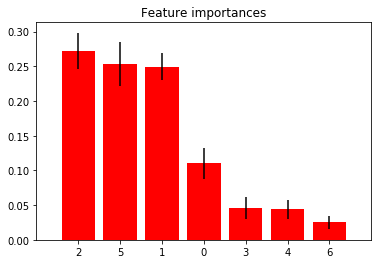

In [93]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

print(x_test.columns)
for f in range(x_test.shape[1]):
    print(f"{f + 1}. feature {x_test.columns[indices[f]]} ({importances[indices[f]]})" )

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_test.shape[1]), indices)
plt.xlim([-1, x_test.shape[1]])

## Adaboost

Confusion matrix, without normalization
[[111  16]
 [ 20  67]]


Clf score: 189


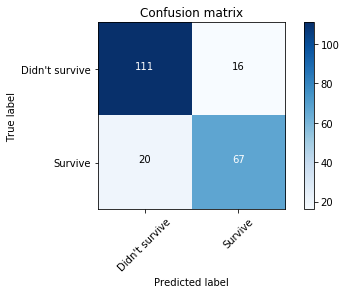

In [84]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=0)
clf.fit(x_train, y_train)

pred = clf.predict(x_test)
plot_confusion_matrix(confusion_matrix(y_test, pred))
print(f'\n\nClf score: {get_pred_score(y_test, pred)}')